In [1]:
import gc
gc.collect()

0

In [2]:
import pandas as pd 

df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
#Remove negative Qty items
df = df[df['Quantity']>0]

# Convert the 'InvoiceDate' column to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add a 'TotalCost' column for the sales
df['TotalCost'] = df['UnitPrice'] * df['Quantity']


In [4]:
# Factorize (encoding) categorical variables
df['CountryCode'] = pd.factorize(df['Country'])[0]
df['StockCodeNumeric'] = pd.factorize(df['StockCode'])[0]

In [5]:
# Assuming we'll cluster based on 'TotalCost', 'CountryCode', and 'StockCodeNumeric'
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
clustering_features = df[['TotalCost', 'UnitPrice', 'CountryCode', 'StockCodeNumeric']]

# Scale the features
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_features)



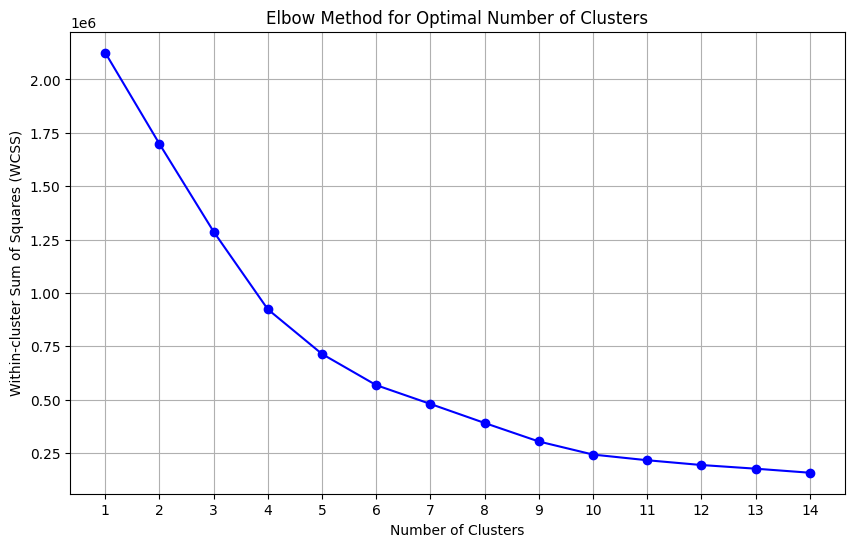

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'features_scaled' is the scaled data prepared for clustering
# Calculate the within-cluster sum of squares (WCSS) for different numbers of clusters
wcss = []
cls = 15 # We will test for 1 to 'cls' clusters
for i in range(1, cls):  
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(clustering_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, cls), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(range(1, cls))
plt.grid(True)
plt.show()



In [7]:
#number of clusters based on the Elbow method

# Apply K-means clustering
# 4, 5 and 10 seem to be clear inflection points
kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(clustering_scaled)

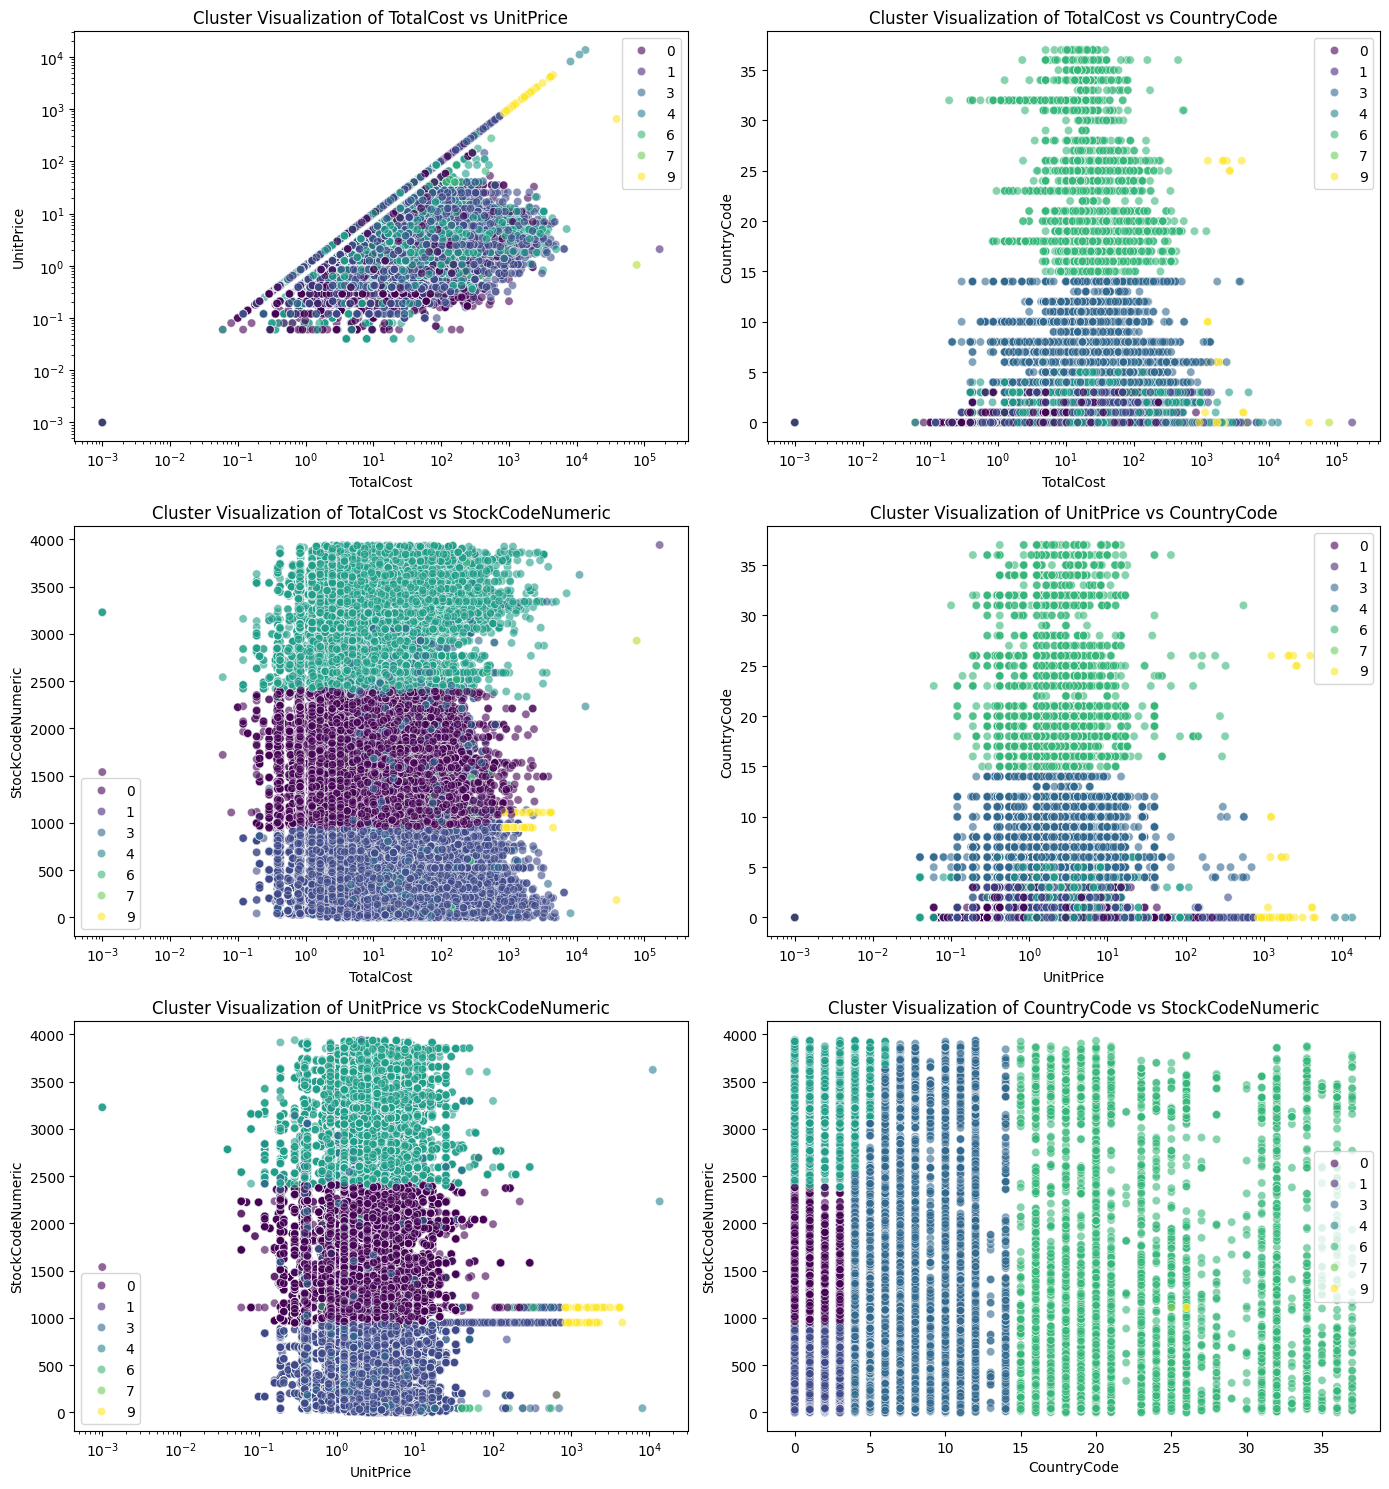

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Plot scatter plots for every combination of the clustering features
feature_combinations = list(combinations(clustering_features.columns, 2))

# Calculate the number of rows needed for subplots
num_plots = len(feature_combinations)
num_rows = num_plots // 2 + num_plots % 2

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, num_rows*5))
axes = axes.flatten()  # Flatten the array of axes

for i, (f1, f2) in enumerate(feature_combinations):
    sns.scatterplot(data=df, x=f1, y=f2, hue='Cluster', palette='viridis', alpha=0.6, ax=axes[i])
    axes[i].set_title(f'Cluster Visualization of {f1} vs {f2}')
    if 'TotalCost' in [f1, f2]:  # Check if one of the axes should be log-scaled
        axes[i].set(yscale='log') if f2 == 'TotalCost' else axes[i].set(xscale='log')
    if 'UnitPrice' in [f1, f2]:  # Check if one of the axes should be log-scaled
        axes[i].set(yscale='log') if f2 == 'UnitPrice' else axes[i].set(xscale='log')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()



Cluster
0    133564
1         1
2    250754
3     24893
4         3
5    116381
6      5600
7         2
8         1
9        86
Name: count, dtype: int64


/var/folders/0f/214wbrld1gbdvhd6jrv5q2380000gn/T/ipykernel_64984/2561163216.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
/Users/surya/Documents/personal/kaggle/venv_kaggle/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/surya/Documents/personal/kaggle/venv_kaggle/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_s

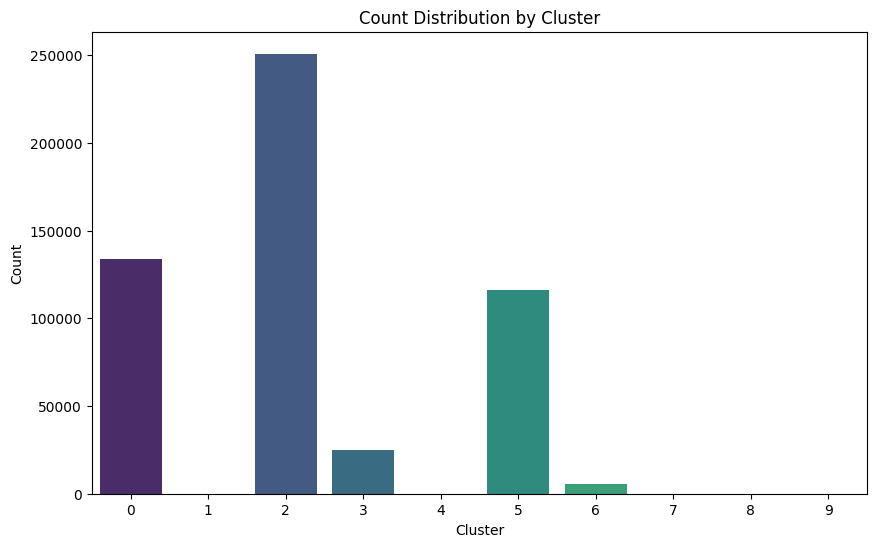

In [27]:
# Assuming the 'df' DataFrame already has the 'Cluster' column from previous KMeans clustering
cluster_counts = df['Cluster'].value_counts().sort_index()

# Print the count distribution by cluster
print(cluster_counts)

# Optionally, visualize the count distribution by cluster as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('Count Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# Good distribution across 5 clusters viz. 0, 2, 3, 5, 6

The above situation occurs owing to extreme outliers in the dataset. We will now attempt to build a time-series based forecasting model for each of the 5 clusters (ignoring the idiosyncratic outlier scenarios)